## Introduction

### Why Offline-RL?

Training of RL algorithms require **active interaction** with the environment. Training can become quite time-consuming and expensive. It can even be dangerous in safety-critical domains like driving or healthcare. A trial-and-error procedure is basically prohibited. We cannot as an example let an agent explore, make mistakes, and learn while treating patients in a hospital.
That's what makes learning from pre-collected experience so relevant. And fortunately we have already in many domains existing large datasets.
Offline-RL therefore aims to learn policies using only these pre-collected data without further interactions with the environment.

![Online and Offline Reinforcement Learning](figures/offline_rl.gif)
<!--- adjust size and center -->

### What properties make offline-RL difficult?

But offline RL comes with its own challenges. By far the biggest problem are so called **out of distribution (OOD) actions**. OOD actions refer to actions taken by an agent that fall outside the range of actions observed in the training dataset. 
State-action space can become so vast that the dataset cannot cover all of it. Especially narrow and biased datasets lack significant coverage and can lead to problems with OOD actions. For example, healthcare datasets are often biased towards serious cases. Only seriously ill people are getting treated, while healthier people are sent home untreated.
![Exampe OOD actions](figures/ood_medicine.png)
<!--- adjust size -->
A naive algorithm might now conclude that treatment causes death, since there were no fatalities in the untreated (= healthy) patients. Choosing to not treat a severely sick patient is something that never happened in the data, since the doctor would thereby violate his duty of care. Not treating a sick patient is therefore an OOD action. 
Vanilla RL algorithm might heavily overestimate the Q-values of OOD state-action pairs.

### How to deal with OOD state-actions?

"Avoid OOD state-actions!", has been the approach of many offline RL algorithms. This can be achieved by regularizing the policy to be close to the behavior policy that was used to collect the data. A more recent approach is to penalize the Q-values to be more pessimistic as done in Conservative Q-learning for Offline RL (CQL).
But if we use this approach we require either (a) an estimation of the behavior policy or (b) explicit sampling from OOD data points (difficult!). Further, we prohibit our agent to approach any OOD state-actions, while some of these might actually be good. Q-function networks **do** have the ability to generalize. It's all about **handling the uncertainty** of these predictions. The agent might benefit from choosing some OOD data points which Q-values we can predict with high confidence.
With SAC-N and EDAC An et al. (2021) found a way of **effectively quantifying the Q-value estimates** by an ensemble of Q-function networks. In this blog we will explore and explain them.

## The Basics


### Q-Learning
Like in standard reinforcement learning we want to find a policy $\pi(a | s)$ that maximizes the cumulative discounted reward $\mathbb{E}_{s_t, a_t}[...]$. 
The model-free [Q-learning](https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c) algorithm is a very common approach to learn the Q-function $Q_{\phi}(s,a)$ with-in a neural network.

### Actor-critic method
In the standard deep actor-critic approach we use two networks: (1) a policy-based actor network and (2) a value-based critic network.

![Strucutre of deep actor-critic RL](https://www.mdpi.com/applsci/applsci-10-04236/article_deploy/html/images/applsci-10-04236-g005.png)
The critic network minimizes the Bellman residual. Note: In offline RL transitions are sampled from a static dataset $D$

![text](./pictures/critic_formula.png)

The actor network is updated in an alternating fashion to maximizes the expected Q-value.

![text](./pictures/actor_formula.png)

### Conservative Q-Learning

As of 2021, [Conservative Q-Learning](https://arxiv.org/abs/2006.04779) (CQL) is the state-of-the-art for offline RL. It uses a “simple Q-value regularizer” to prevent the overestimation of OOD actions. 

![text](./pictures/cql.png)

For each state, CQL computes a distribution over actions using a temperature parameter $\alpha$ that controls the amount of exploration. The distribution is a mixture of the behavior policy and the current Q-function. The closer $\alpha$ is to 1 the more conservative.

CQL will be used as the baseline.






## Dataset

## Soft Actor-Critic (SAC-N)

The paper introduces two new methods for offline RL. The first method is called SAC-N and is an extension of Soft Actor-Critic (SAC) [@Haarnoja2018SoftAO], which is a popular off-policy actor-critic deep RL algorithm.
SAC-N extends SAC by using the minimum q-value of N instead of two q-functions, i.e. critics. The idea behind using the minimum of more critics is that the resulting q-value is more pessimistic when the uncertainty is high. This prevents erroneously high q-values of OOD actions and therefore trains the actor to prefer safer actions.

The minimum of multiple critics approximates the true q-value minus a multiple of the standard deviation [@an2021edac]:

$$ \mathbb{E}\left [\min_{i=1,...,N}Q_i\right] \approx m - \Phi^{-1}\left(\frac{N-\pi/8}{N-\pi/4+1}\right) \sigma $$

Where $N$ is the number of critics, $Q_i$ is the q-value of the $i$-th critic, $m$ is the theoretical true q-value, $\Phi$ is the CDF of the standard gaussian distribution, and $\sigma$ is the standard deviation.

This is visualized in the diagram below, where q-value estimates over an exemplary action space are plotted.The black line is the theoretical true q-value and the grey area its standard deviation. The lightblue lines represent the critics, that try to approximate the true q-value. The bottom blue line is the minimum of the critics, that should, especially for a high number of critics, be roughly the true q-value minus a multiple of the standard deviation. You can use the slider to change the number of critics:

```{ojs}
//| echo: false
means = [0,2,-1,0,1,1,2,0,-1,-2,0,1,2,4,3,3,1,0,-1,0];
stds  = [2,3, 2,1,2,3,2,3, 4, 2,3,4,2,1,3,2,1,2, 3,2];
viewof num_critics = Inputs.range([1,50], {value:20, step:1, label: "#critics: "});
function gaussianRandom(mean=0, stdev=1) {
    let u = 1 - Math.random(); // Converting [0,1) to (0,1]
    let v = Math.random();
    let z = Math.sqrt(-2.0*Math.log(u)) * Math.cos(2.0*Math.PI*v);
    return z * stdev + mean;
}
function example_critic() {
  return [...Array(means.length).keys()].map((i)=>gaussianRandom(means[i], stds[i]));
}
function toPlot(data, color){
  return Plot.line(data.map((x, i)=>({"action space": i, "q-value": x})), {x: "action space", y: "q-value", stroke: color});
}
critics = [...Array(num_critics).keys()].map(i=>example_critic());
Plot.plot({
  marks: [
      Plot.areaY(means.map((x,i)=>({"action space": i, low:x-stds[i], high:x+stds[i]})), {x: "action space", y1: "low", y2: "high", fill: "#ddd"}),
      ...(critics.map(x=>toPlot(x, "lightblue"))),
      toPlot([...Array(means.length).keys()].map(i=>Math.min(...critics.map(x=>x[i]))), "blue"),
      toPlot(means, "black"),
  ],
  y: {
    domain: [-10,10],
    label: "q-value",
  },
  x: {
    tickFormat: x => "",
  }
});
```

SAC-N already achieves notable performance and beats the previous state of the art, CQL, as will be shown in [Results](#results). However, SAC-N requires a large number of critics, which comes with a high computational cost. Therefore, the paper introduces a second method, EDAC, that is more efficient.


## Ensemble-Diversified Actor Critic (EDAC)

EDAC improves over SAC-N, by introducing an ensemble gradient diversification term to the optimization of the ensemble of critics:

$$ \underset\phi{\text{minimize}}\ \ \frac{1}{N-1} \sum_{1\leq i\neq j \leq N} \langle \nabla_a Q_{\phi_i}, \nabla_a Q_{\phi_j} \rangle $$


## Results

{{< video "figures/EDAC reimplementation halfcheetah.mp4" >}}
This is a our edac reimplementation on the halfcheetah task.

TODO

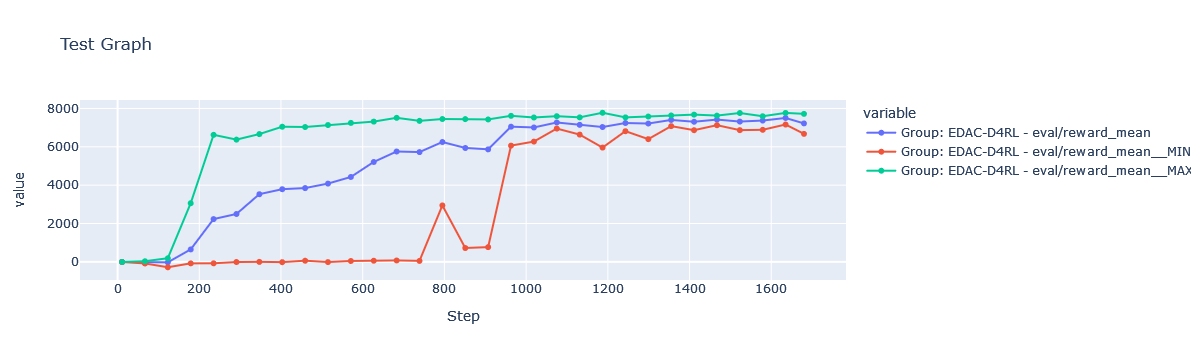

In [6]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('data/test.csv')

fig = px.line(df, x="Step", 
              y=["Group: EDAC-D4RL - eval/reward_mean","Group: EDAC-D4RL - eval/reward_mean__MIN","Group: EDAC-D4RL - eval/reward_mean__MAX"],
             title="Test Graph",
             markers=True)

fig.show()

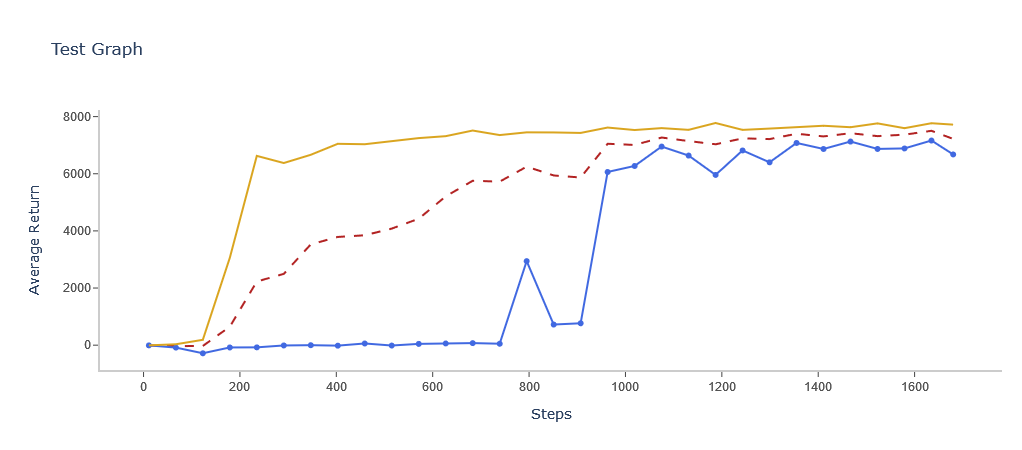

In [29]:
import pandas as pd
import plotly.graph_objects as go

df = pd.read_csv('data/test.csv')

# Build figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=df["Step"], y=df["Group: EDAC-D4RL - eval/reward_mean"], name='Line 1',
                         line=dict(color='firebrick', width=2, dash='dash')))

fig.add_trace(go.Scatter(x=df["Step"], y=df["Group: EDAC-D4RL - eval/reward_mean__MIN"], name='Line 2',
                         mode='lines+markers', line=dict(color='royalblue', width=2,)))

fig.add_trace(go.Scatter(x=df["Step"], y=df["Group: EDAC-D4RL - eval/reward_mean__MAX"], name='Line 3',
                         line=dict(color='goldenrod', width=2)))

fig.update_layout(
    title='Test Graph',
    xaxis=dict(
        title="Steps",
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        title="Average Return",
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        )
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)

fig.show()

```{python}
#| label: test-label
#| fig-cap: "fig-cap example"

import pandas as pd
import plotly.graph_objects as go

df = pd.read_csv('data/test.csv')

# Build figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=df["Step"], y=df["Group: EDAC-D4RL - eval/reward_mean"], name='Line 1',
                         line=dict(color='firebrick', width=2, dash='dash')))

fig.add_trace(go.Scatter(x=df["Step"], y=df["Group: EDAC-D4RL - eval/reward_mean__MIN"], name='Line 2',
                         mode='lines+markers', line=dict(color='royalblue', width=2,)))

fig.add_trace(go.Scatter(x=df["Step"], y=df["Group: EDAC-D4RL - eval/reward_mean__MAX"], name='Line 3',
                         line=dict(color='goldenrod', width=2)))

fig.update_layout(
    title='Test Graph',
    xaxis=dict(
        title="Steps",
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        title="Average Return",
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        )
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=True,
    plot_bgcolor='white'
)

fig.show()
```